In [1]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Flatten
import tensorflow_model_optimization as tfmot
import keras
from keras.utils import plot_model
import pydot, graphviz
from random import random
#The model was trained on a tensorflow (Keras) version higher than the one you want to use to load the trained model. Find the compatible version of TensorFlow (Keras).
#https://stackoverflow.com/questions/60562216/cant-load-keras-model-using-rectifiedadam-optimizer
#from tensorflow_addons.optimizers import RectifiedAdam
#tf.keras.optimizers.RectifiedAdam = RectifiedAdam

In [2]:
df = pd.read_csv('../ml/dataset_management/refit/kettle/kettle_training_.csv').to_dict()
df['aggregate'] = {key: df['aggregate'][key] for key in range(10)}
df['kettle'] = {key: df['kettle'][key] for key in range(10)}

In [3]:
# Annahme: Input-Daten haben die Form (batch_size, sequence_length, num_features)
# https://stackoverflow.com/questions/61029052/what-is-the-batchsize-in-tensorflows-model-fit-function
num_features = 5
window_length = 20
batch_size = num_features * 200
model = Sequential()
rnd = 1

In [4]:
'''
# Input Layer
model.add(Input(shape=(batch_size, window_length)))
model.add(tf.keras.layers.Reshape(target_shape=(batch_size, window_length, 1)))
model.add(tf.keras.layers.Convolution2D(filters=16, kernel_size=(1, 5), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2), padding='same'))
model.add(tf.keras.layers.Flatten())
#...
model.add(tf.keras.layers.Dense(batch_size * num_features, activation='linear'))
'''

"\n# Input Layer\nmodel.add(Input(shape=(batch_size, window_length)))\nmodel.add(tf.keras.layers.Reshape(target_shape=(batch_size, window_length, 1)))\nmodel.add(tf.keras.layers.Convolution2D(filters=16, kernel_size=(1, 5), padding='same'))\nmodel.add(tf.keras.layers.Activation('relu'))\nmodel.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2), padding='same'))\nmodel.add(tf.keras.layers.Flatten())\n#...\nmodel.add(tf.keras.layers.Dense(batch_size * num_features, activation='linear'))\n"

In [5]:
# input layer
#model.add(Input(shape=(batch_size, window_length)))
#model.add(tf.keras.layers.Reshape(target_shape=(batch_size, window_length)))

model.add(Input(shape=(window_length)))
model.add(tf.keras.layers.Reshape(target_shape=(window_length, 1)))

# conv1 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv2 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv3 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# gap
model.add(tf.keras.layers.GlobalAveragePooling1D())
# output layer
model.add(tf.keras.layers.Dense(num_features, activation="softmax"))

In [6]:
'''
# TensorBoard 2.15.1 at http://localhost:6006/
keras.callbacks.TensorBoard(
    log_dir="/Users/Olaf/Documents/GitHub/NonIntrusiveLoadMonitoring/TestModel/log",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)
'''

'\n# TensorBoard 2.15.1 at http://localhost:6006/\nkeras.callbacks.TensorBoard(\n    log_dir="/Users/Olaf/Documents/GitHub/NonIntrusiveLoadMonitoring/TestModel/log",\n    histogram_freq=0,  # How often to log histogram visualizations\n    embeddings_freq=0,  # How often to log embedding visualizations\n    update_freq="epoch",\n)  # How often to write logs (default: once per epoch)\n'

In [7]:
# Kompilieren des Modells
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'msle', 'mae'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['mse', 'msle', 'mae'])
# Anzeigen der Modellzusammenfassung
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 20, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 batch_normalization (Batch  (None, 20, 64)            256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 20, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            12352     
                                                                 
 batch_normalization_1 (Bat  (None, 20, 64)            256       
 chNormalization)                                       

In [9]:
# feature1
def generate_feature(base, peak, width=6, amount=1, rnd=0, size=10) :
    a = np.array([])
    for t in range(amount) :
        a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(1)])
        a = np.append(a, [peak + (random() - 0.5) * abs(rnd) for i in np.arange(size // amount - 2)])
        a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(1)])
    a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(size % amount)]) # correction for uneven num_features
    return a

In [10]:
feature1 = generate_feature(base=0, peak=5, amount=3, rnd=1, size=10)
#print(feature1)
#plt.plot(feature1)

In [11]:
x = np.array([])
y = np.array([])
for f in range(num_features) :
    #print("f: ", f)
    for i in range(int(batch_size / num_features)) :
        #print("i: ",i)
        x = np.append(x, generate_feature(base=0, peak=5-f, amount=1+f, rnd=rnd, size=window_length))
        new_targets = np.zeros(num_features)
        new_targets[f] = 1
        y = np.append(y, new_targets)
        #print(y)
        #print("f, i, y[f]: ", f, " ", i, " ", y[f])

In [34]:
#for i in range(num_features) :
#    plt.plot(x[])

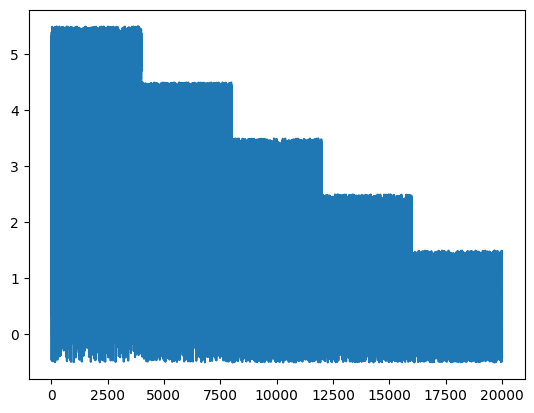

In [12]:
#print(x)
plt.plot(x)

In [13]:
print(np.size(x))
print(np.size(y))

20000
5000


In [14]:
x = x.reshape((batch_size, window_length))
y = y.reshape((batch_size, num_features))

In [15]:
#print(x)
print(np.shape(x))
print(np.size(x))

(1000, 20)
20000


In [16]:
#y = y.reshape(1, 2, 2)
#print(y)
print(np.shape(y))
print(np.size(y))

(1000, 5)
5000


In [17]:
#plt.plot(x[0][9])

In [18]:
#print(y[0])

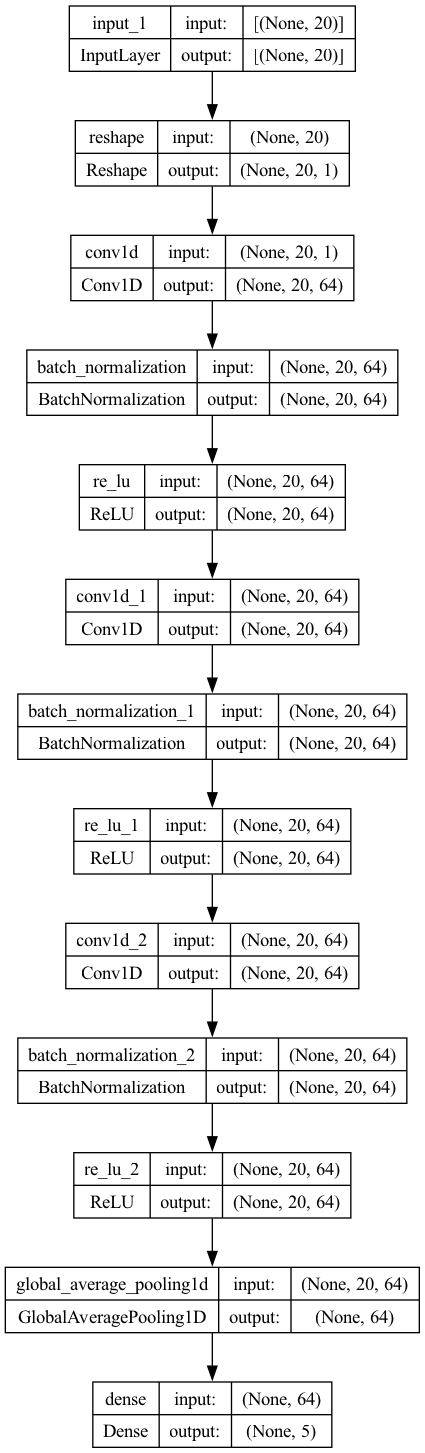

In [19]:
keras.utils.plot_model(model, "my_new_nilm_model.png", show_shapes=True)

In [20]:
# train the model
history = model.fit(
            #x=x.reshape(1, batch_size, window_length),
            #y=y.reshape(1, batch_size, num_features),
            x=x.reshape(batch_size, window_length),
            y=y.reshape(batch_size, num_features ),
            batch_size=batch_size,
            epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 402ms/step - loss: 0.2111 - mse: 0.2111 - msle: 0.1073 - mae: 0.3530
Epoch 2/100
1/1 [==============================] - 0s 29ms/step - loss: 0.1658 - mse: 0.1658 - msle: 0.0822 - mae: 0.3219
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1320 - mse: 0.1320 - msle: 0.0638 - mae: 0.2845
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1075 - mse: 0.1075 - msle: 0.0515 - mae: 0.2500
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0908 - mse: 0.0908 - msle: 0.0432 - mae: 0.2227
Epoch 6/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0786 - mse: 0.0786 - msle: 0.0372 - mae: 0.2022
Epoch 7/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0687 - mse: 0.0687 - msle: 0.0324 - mae: 0.1862
Epoch 8/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0602 - mse: 0.0602 - msle: 0.0281 - mae: 0.1731
Epoch 9/100
1/1 [======

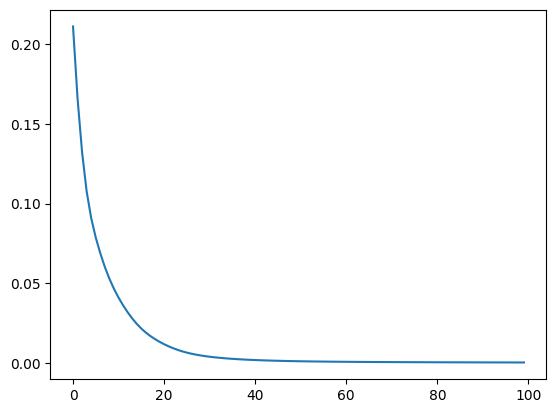

In [21]:
plt.plot(history.history['loss'])

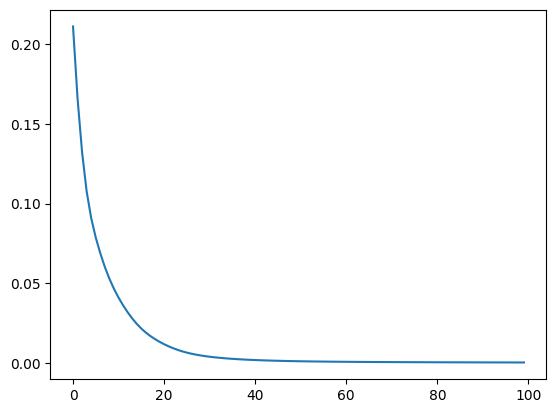

In [22]:
plt.plot(history.history['mse'])

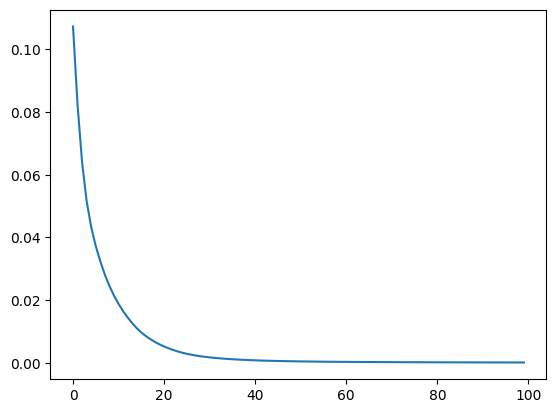

In [23]:
plt.plot(history.history['msle'])

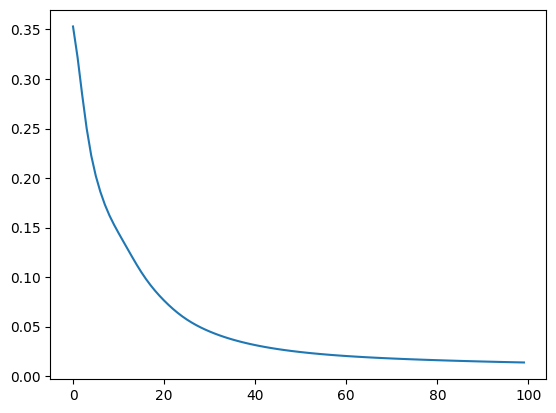

In [24]:
plt.plot(history.history['mae'])

In [25]:
model.save("my_new_nilm_model.keras")

In [26]:
test_batch_size  = 2000
test_x = np.array([])
test_y = np.array([])
for f in range(num_features) :
    for i in range(int(test_batch_size / num_features)) :
        test_x = np.append(test_x, generate_feature(base=0, peak=5-f, amount=1+f, rnd=rnd, size=window_length))
        new_targets = np.zeros(num_features)
        new_targets[f] = 1
        test_y = np.append(test_y, new_targets)

In [27]:
test_x = test_x.reshape((test_batch_size, window_length))
test_y = test_y.reshape((test_batch_size, num_features))



In [28]:
# loss='mse', metrics=['mse', 'msle', 'mae']
test1, test2, test3, test4 = model.evaluate(test_x, test_y)

63/63 [==============================] - 0s 2ms/step - loss: 0.1151 - mse: 0.1151 - msle: 0.0556 - mae: 0.2401


In [29]:
predict_x = test_x
predict_x = predict_x.reshape(predict_x.shape[0], window_length)

In [30]:
predict_y = model.predict(predict_x)
print(predict_y)

63/63 [==============================] - 0s 1ms/step
[[0.89776814 0.03079217 0.00920681 0.02462397 0.03760895]
 [0.8892596  0.03480227 0.00990205 0.02648458 0.03955162]
 [0.87373406 0.04169307 0.01162366 0.02964717 0.04330204]
 ...
 [0.09089492 0.07872151 0.15231377 0.43210837 0.24596152]
 [0.09081529 0.08050909 0.15200731 0.4389064  0.2377619 ]
 [0.09099688 0.07740992 0.1506323  0.40650025 0.27446064]]


In [31]:
predict_y.shape[0]

2000

In [32]:
predict_y

array([[0.89776814, 0.03079217, 0.00920681, 0.02462397, 0.03760895],
       [0.8892596 , 0.03480227, 0.00990205, 0.02648458, 0.03955162],
       [0.87373406, 0.04169307, 0.01162366, 0.02964717, 0.04330204],
       ...,
       [0.09089492, 0.07872151, 0.15231377, 0.43210837, 0.24596152],
       [0.09081529, 0.08050909, 0.15200731, 0.4389064 , 0.2377619 ],
       [0.09099688, 0.07740992, 0.1506323 , 0.40650025, 0.27446064]],
      dtype=float32)

In [33]:
cnt_wrong = 0
cnt_correct = 0

for i in range(predict_y.shape[0]) :
    predicted_pos = np.argmax(predict_y[i])
    trained_pos =  np.argmax(test_y[i])
    if predicted_pos != trained_pos :
        cnt_wrong = cnt_wrong + 1
        #print("predicted feature: ", predicted_pos, " and trained feature: ", trained_pos)
        print("predicted: ", predict_y[i], " and trained: ", test_y[i])
    else :
        cnt_correct = cnt_correct + 1

print("predictions... ")
print(" total:   ", cnt_wrong + cnt_correct)
print(" correct: ", cnt_correct)
print(" wrong:   ", cnt_wrong)

predicted:  [0.43556237 0.33223894 0.0541862  0.08814047 0.08987195]  and trained:  [0. 1. 0. 0. 0.]
predicted:  [0.43247733 0.3350454  0.05578437 0.08766843 0.08902444]  and trained:  [0. 1. 0. 0. 0.]
predicted:  [0.46265638 0.30530784 0.05359399 0.08709992 0.09134187]  and trained:  [0. 1. 0. 0. 0.]
predicted:  [0.40580922 0.35648486 0.05642075 0.09191249 0.08937269]  and trained:  [0. 1. 0. 0. 0.]
predicted:  [0.47086912 0.2972925  0.05330329 0.08719069 0.09134434]  and trained:  [0. 1. 0. 0. 0.]
predicted:  [0.4470239  0.31837434 0.05504259 0.08833207 0.09122706]  and trained:  [0. 1. 0. 0. 0.]
predicted:  [0.43547088 0.33148292 0.05655077 0.08727089 0.08922453]  and trained:  [0. 1. 0. 0. 0.]
predicted:  [0.44525212 0.32089487 0.05546334 0.0879037  0.09048598]  and trained:  [0. 1. 0. 0. 0.]
predicted:  [0.40046713 0.3605669  0.05903299 0.09077053 0.08916238]  and trained:  [0. 1. 0. 0. 0.]
predicted:  [0.5069335  0.2697911  0.0509162  0.08276427 0.0895949 ]  and trained:  [0. 1. 